In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Layer, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance

#load in arrays from spectra generator

dets = 10

nu_e = np.load(f'nu_e_{dets}.npy')
flux = np.load(f'flux_{dets}.npy')
sin_sqs = np.load('sin_sqs.npy') 
dm_sqs = np.load('dm_sqs.npy')
osc_params = np.load('osc_params.npy')
fd_spectra = np.load('fd_spectra.npy')
bin_centers_saved = np.load('bin_centers.npy')

print(nu_e.shape)
print(flux.shape)
print(osc_params.shape)
print(fd_spectra.shape)

(10, 300, 800)
(10, 300, 800)
(10000, 2)
(10000, 100)


In [3]:
param1, param2 = zip(*osc_params)
print(np.min(param1))
print(np.min(param1),np.max(param1),np.min(param2),np.max(param2))

0.9
0.9 1.0 0.002 0.00295


In [15]:

#set spectra limits and num bins
E_min, E_max, bins = 0, 5, 100
n_dets = nu_e.shape[0]
edges = np.linspace(E_min, E_max, bins+1)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_widths = np.diff(edges)


#put the nd spectra into a single array
hists = []
for i in range(n_dets):
    pred_e = nu_e[i].flatten()
    pred_w = flux[i].flatten()

    # Histogram without normalization
    hist, _ = np.histogram(pred_e, bins=edges, weights=pred_w, density=False)
    hists.append(hist)

nd_spectra = tf.constant(np.array(hists), dtype=tf.float32) 
print(np.mean(nd_spectra)/np.mean(fd_spectra))
nd_spectra *= np.mean(fd_spectra)/np.mean(nd_spectra) #resize the ND spectra 
n_sections, n_bins = nd_spectra.shape
num_runs = fd_spectra.shape[0]




8.29435634841502e-05


In [17]:
#put the flux arrays into nd_spectra

def create_nd_spectra(nu_e, flux):
    hists = []
    
    for i in range(nu_e.shape[0]):
        pred_e = nu_e[i].flatten()
        pred_w = flux[i].flatten()
    
        # Histogram without normalization
        hist, _ = np.histogram(pred_e, bins=edges, weights=pred_w, density=False)
        hists.append(hist)

    nd_spectra = tf.constant(np.array(hists), dtype=tf.float32) 
    nd_spectra *= np.mean(fd_spectra)/np.mean(nd_spectra) #resize the ND spectra 
    return nd_spectra
    

In [19]:
edges

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  ])

In [36]:
#create custom layer to use in model

class CombineNDandOsc(Layer):
    def __init__(self, nd_spectra):
        super().__init__()
        self.nd_const = tf.constant(nd_spectra, dtype=tf.float32)  
        self.n_sections = nd_spectra.shape[0]
        self.n_bins = nd_spectra.shape[1]
        self.dense = Dense(self.n_sections, activation='softmax')

    def call(self, params):
        batch_size = tf.shape(params)[0]
        nd_tiled = tf.tile(self.nd_const[None, :, :], [batch_size, 1, 1]) 

        weights = self.dense(params)            
        weights = tf.expand_dims(weights, -1)   

        combined = tf.reduce_sum(weights * nd_tiled, axis=1) 
        return combined 

In [34]:
def build_model(nd_spectra):
    """
    Builds a Keras model to predict FD spectra from oscillation parameters and fixed ND spectra.
    
    Parameters:
    - nd_spectra: np.ndarray of shape (n_dets, n_bins)
    
    Returns:
    - model: compiled Keras Model
    - early_stop: EarlyStopping callback
    """
    n_dets = nd_spectra.shape[0]
    n_bins = nd_spectra.shape[1]

    # Input layer: oscillation parameters (sin²θ, Δm²)
    osc_input = Input(shape=(2,), name='osc_params')

    # Dense layers
    x = Dense(128, activation='relu')(osc_input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(n_dets, activation='relu')(x)

    # Custom layer: combines ND spectra with weights
    x = CombineNDandOsc(nd_spectra)(x)

    # Final output layer
    x = Dense(n_bins, activation='linear', kernel_regularizer=l2(1e-4))(x)

    # build
    model = Model(inputs=osc_input, outputs=x)

    # compile
    model.compile(optimizer='adam', loss='mse')

    # callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    return model, early_stop


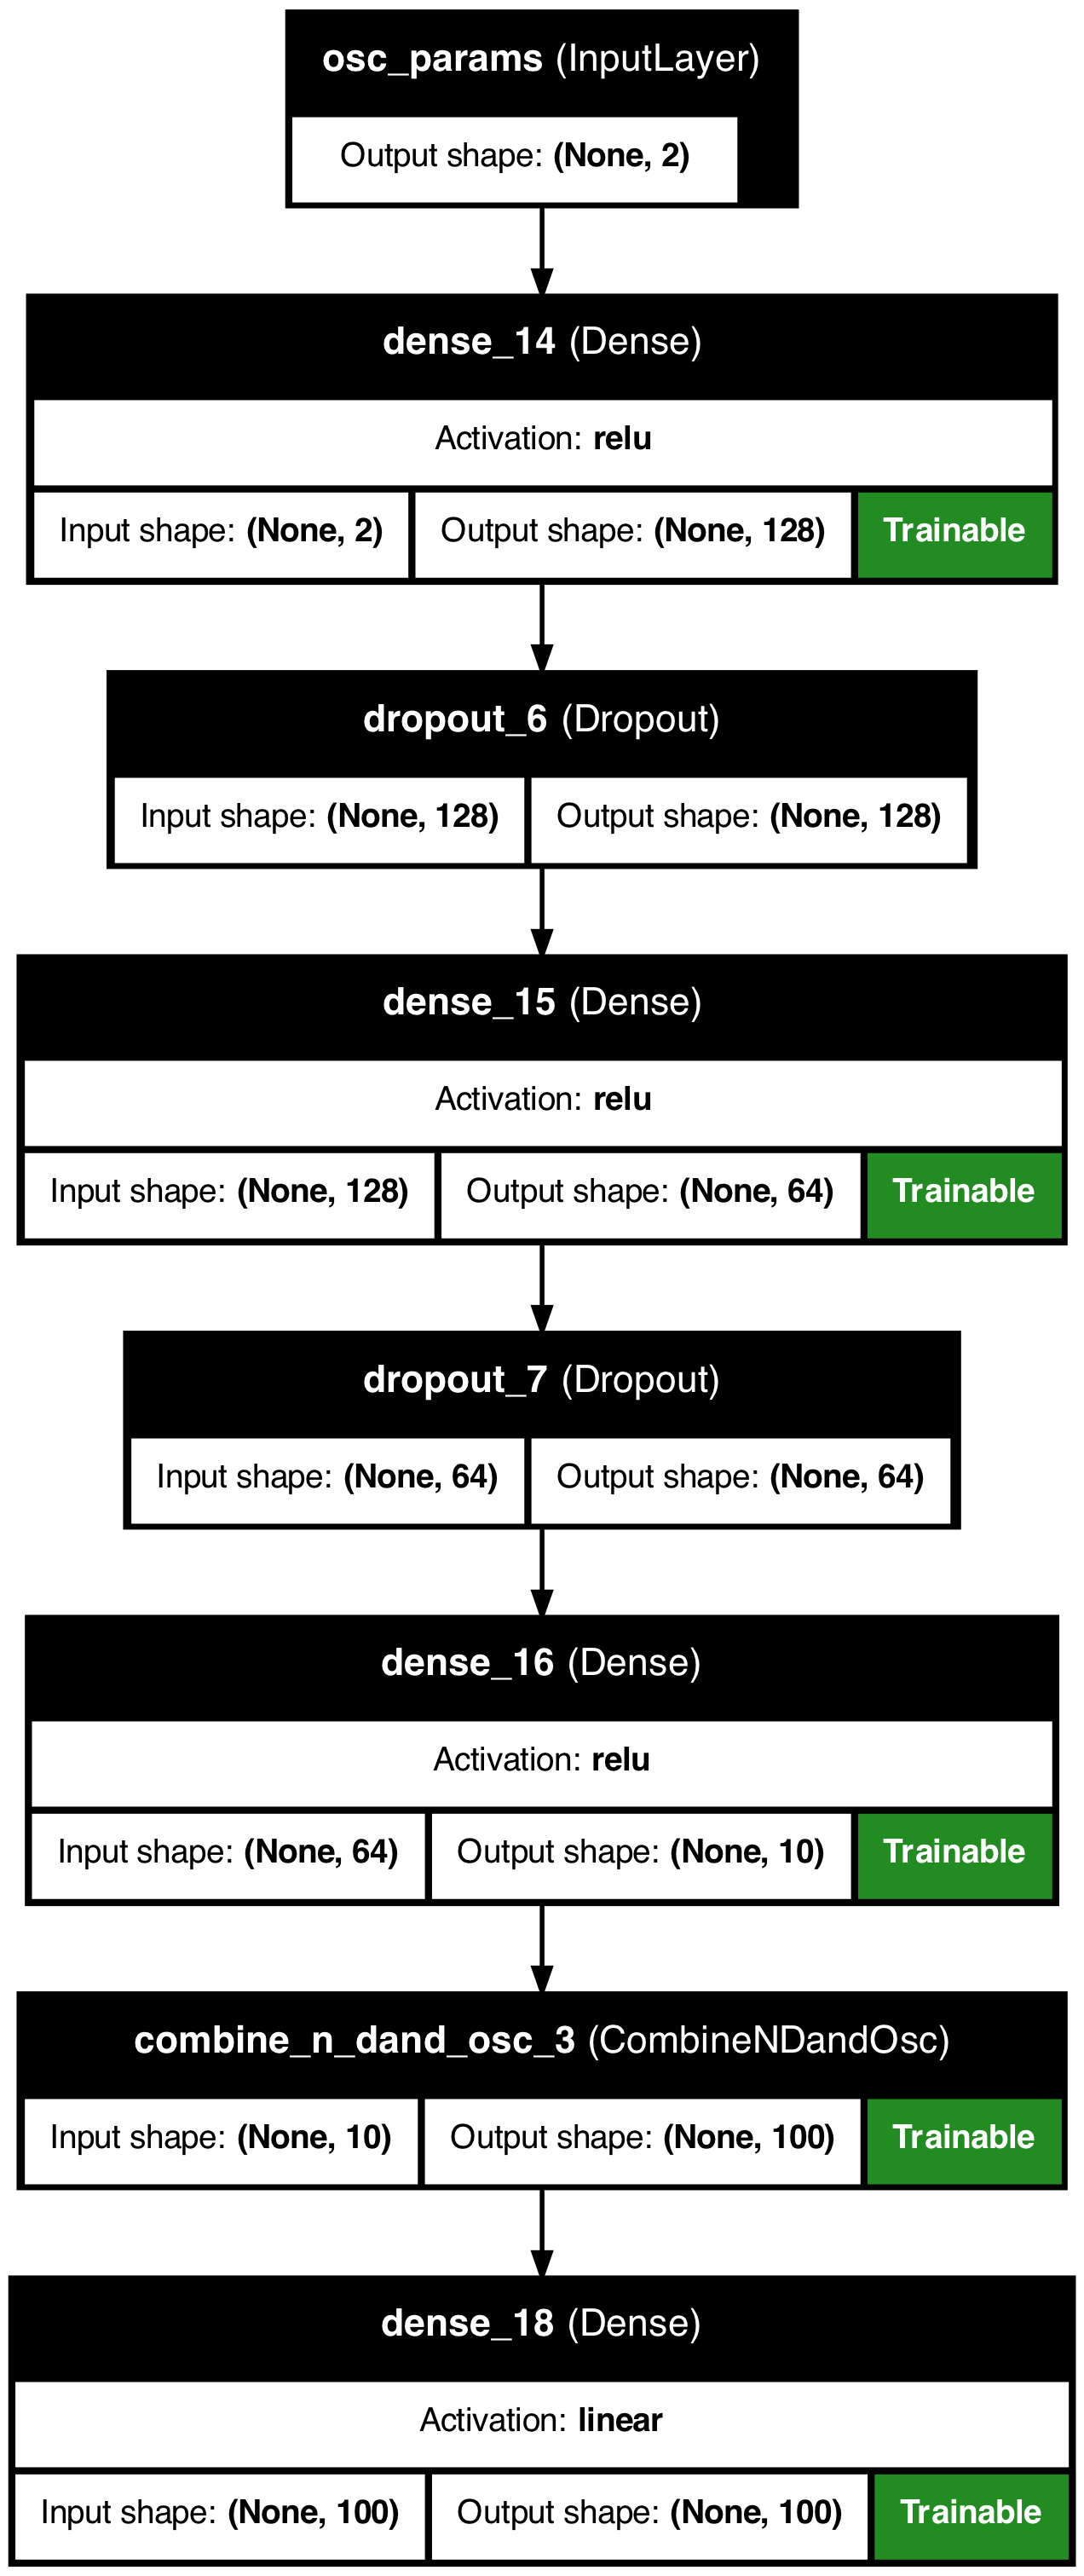

In [52]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
)

In [40]:


X_train, X_test, y_train, y_test = train_test_split(
    osc_params, fd_spectra, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

nd_spectra = create_nd_spectra(nu_e, flux)
model, callbacks = build_model(nd_spectra)

# model.save('NOvA_NN.keras')

history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.1,callbacks=callbacks)

Epoch 1/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - loss: 0.0055 - val_loss: 2.2932e-04
Epoch 2/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 1.2911e-04 - val_loss: 5.0981e-05
Epoch 3/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 4.9558e-05 - val_loss: 4.5821e-05
Epoch 4/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 4.1365e-05 - val_loss: 3.8959e-05
Epoch 5/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 3.8455e-05 - val_loss: 3.8964e-05
Epoch 6/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 3.8312e-05 - val_loss: 3.9077e-05
Epoch 7/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 3.8827e-05 - val_loss: 3.8988e-05
Epoch 8/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 3.8303e-05 - val_loss: 3.9295e-05
Epoch 9/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 3.8630e-05 - val_loss: 3.9046e-05
Epoch 10/500
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 3.8457e-05 - val_loss: 3.9150e-05
Epoch 11/500
189/189 ━━━━━━━━━━━━

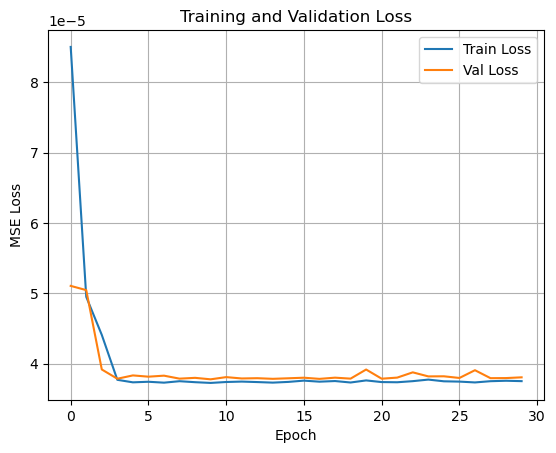

In [51]:
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Train-Validate History.pdf',format='pdf')
plt.grid(True)
plt.show()

ND spectra mean: 0.009999999
FD spectra mean: 0.010000000000000002


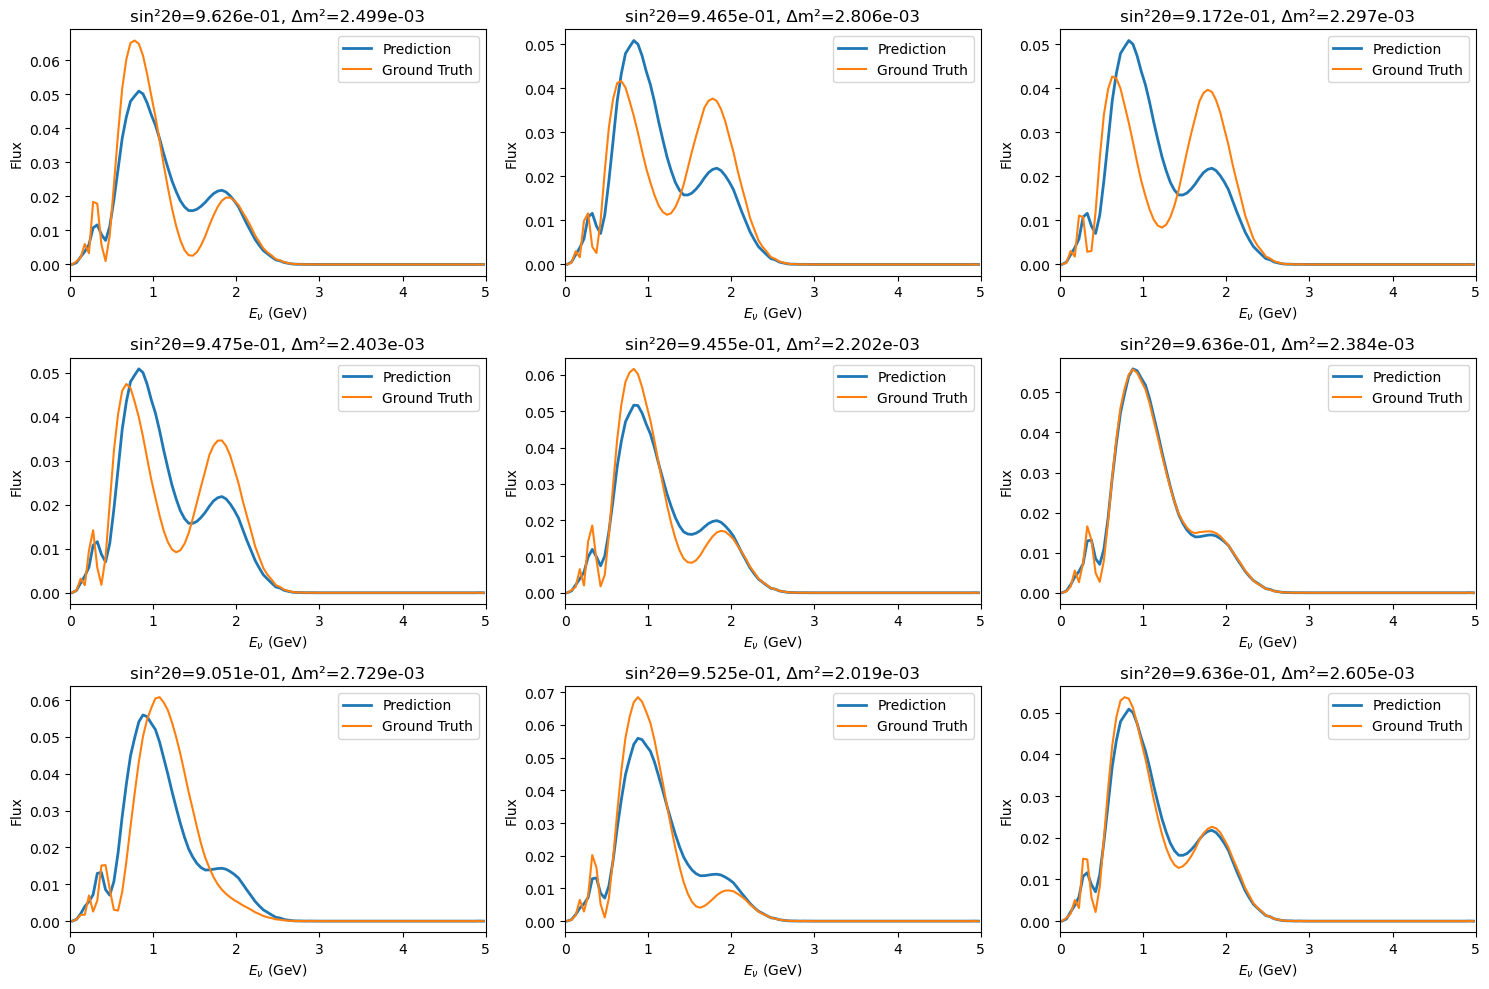

In [53]:
import random

random.seed(42)
indices = random.sample(range(len(X_test_scaled)), 9)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for i, idx in enumerate(indices):
    pred = model.predict(np.array([X_test_scaled[idx]]), verbose=0)[0]
    true = y_test[idx]
    axs[i].set_xlim(0, 5)
    axs[i].plot(bin_centers, pred, label='Prediction', linewidth=2)
    axs[i].plot(bin_centers, true, label='Ground Truth')
    axs[i].set_title(f"sin²2θ={X_test[i][0]:.3e}, Δm²={X_test[i][1]:.3e}")
    axs[i].set_xlabel(r"$E_\nu$ (GeV)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()

plt.tight_layout()
plt.savefig('Sample FD predicted spectra.pdf',format='pdf')
plt.show()

In [63]:
#test errors by num ND sections

df = pd.DataFrame(columns=['ND_num', 'mse', 'mae','cosine_sim'])

for sec in range(2,11):

    #load nd fluxes
    nu_e = np.load(f'nu_e_{sec}.npy')
    flux = np.load(f'flux_{sec}.npy')
    
    #create nd_spectra and model
    nd_spectra = create_nd_spectra(nu_e, flux)
    model, callbacks = build_model(nd_spectra)

    #fit model
    history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.1,callbacks=callbacks, verbose=0)


    # Predict using the model
    y_pred = model.predict(X_test_scaled)


    cos_similarities = []

    # Loop over all test samples
    for y_true, y_hat in zip(y_test, y_pred):
        
        norm_true = y_true / (np.sum(y_true) + 1e-8)
        norm_pred = y_hat / (np.sum(y_hat) + 1e-8)
        cos_sim = 1 - cosine(norm_true, norm_pred)
        cos_similarities.append(cos_sim)
     
    
    # scalar metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    #add to df
    df.loc[len(df)] = [sec, mse, mae, np.mean(cos_similarities)]
    metrics = compute_metrics(y_test, model.predict(X_test))
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    # print(f"Mean Squared Error (MSE): {mse:.6f}")
    # print(f"Mean Absolute Error (MAE): {mae:.6f}")
    # print(f"Average Cosine Similarity: {np.mean(cos_similarities):.4f}")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
Pearson: 0.9004
Spearman: 0.9459
EMD: 0.0018
Cosine: 0.9290
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Pearson: 0.8984
Spearman: 0.9430
EMD: 0.0018
Cosine: 0.9278
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
Pearson: 0.8959
Spearman: 0.9440
EMD: 0.0018
Cosine: 0.9259
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
Pearson: 0.8957
Spearman: 0.9310
EMD: 0.0018
Cosine: 0.9258
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
Pearson: 0.8930
Spearman: 0.9440
EMD: 0.0017
Cosine: 0.9239
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
Pearson: 0.8964
Spearman: 0.9449
EMD: 0.0017
Cosine: 0.9262
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
Pearson: 0.8931
Spearman: 0.9344
EMD: 

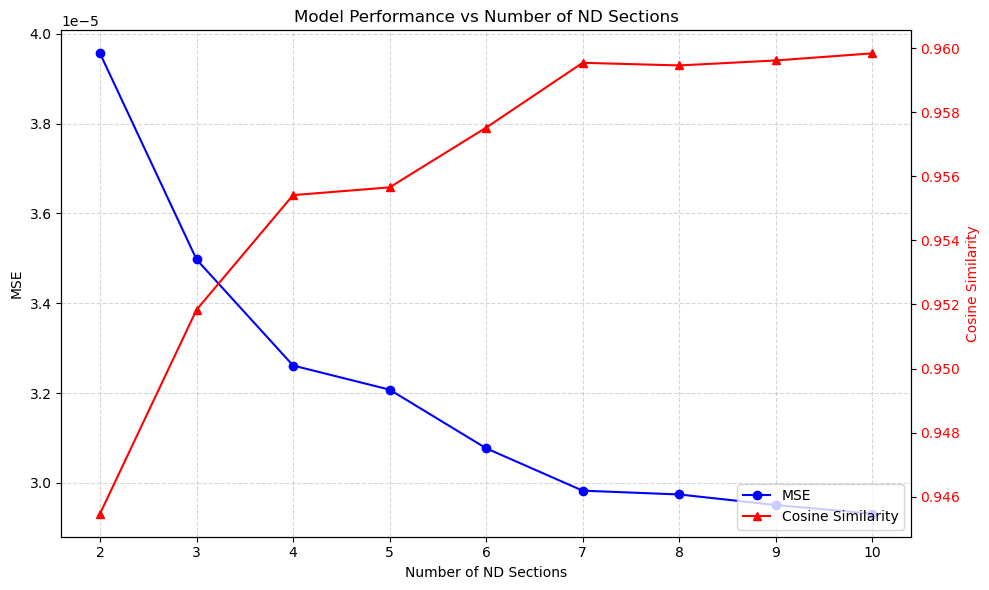

In [122]:
#plot results

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df['ND_num'], df['mse'], 'b-o', label='MSE')
ax1.set_xlabel('Number of ND Sections')
ax1.set_ylabel('MSE', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.5)

# Secondary y-axis for Cosine Similarity
ax2 = ax1.twinx()
ax2.plot(df['ND_num'], df['cosine_sim'], 'r-^', label='Cosine Similarity')
ax2.set_ylabel('Cosine Similarity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

plt.title('Model Performance vs Number of ND Sections')
plt.tight_layout()
plt.savefig('Model Stats vs ND Sections.pdf',format='pdf')
plt.show()

In [59]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance  # EMD for 1D distributions

def compute_metrics(y_true, y_pred):
    """
    y_true, y_pred: arrays of shape (n_samples, n_bins)
    Returns: dict of average Pearson, Spearman, EMD, and Cosine similarity.
    """
    pearsons = []
    spearmans = []
    emds = []
    cos_sims = []

    for true, pred in zip(y_true, y_pred):
        # Pearson
        p_corr, _ = pearsonr(true, pred)
        pearsons.append(p_corr)

        # Spearman
        s_corr, _ = spearmanr(true, pred)
        spearmans.append(s_corr)

        # EMD (1D Wasserstein distance)
        emds.append(wasserstein_distance(true, pred))

        # Cosine similarity
        norm_true = true / (np.linalg.norm(true) + 1e-12)
        norm_pred = pred / (np.linalg.norm(pred) + 1e-12)
        cos_sims.append(1 - cosine(norm_true, norm_pred))  # 1 - cosine distance

    return {
        "Pearson": np.mean(pearsons),
        "Spearman": np.mean(spearmans),
        "EMD": np.mean(emds),
        "Cosine": np.mean(cos_sims)
    }

# Example usage
metrics = compute_metrics(y_test, model.predict(X_test))
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step 
Pearson: 0.8934
Spearman: 0.9436
EMD: 0.0017
Cosine: 0.9242


In [95]:
preds=[]
mid = osc_params[5050].reshape(1,-1)
mid_scaled =  scaler.transform(mid)


for sec in [2,6,10]:

    #load nd fluxes
    nu_e = np.load(f'nu_e_{sec}.npy')
    flux = np.load(f'flux_{sec}.npy')
    
    #create nd_spectra and model
    nd_spectra = create_nd_spectra(nu_e, flux)
    model, callbacks = build_model(nd_spectra)

    #fit model
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1,callbacks=callbacks, verbose=0)


    # Predict using the model
    y_pred = model.predict(mid_scaled)
    preds.append(y_pred)






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [105]:
mid_scaled

array([[0.00840953, 0.00163762]])

In [89]:
mid = osc_params[5050].reshape(1,-1)
mid_scaled =  scaler.transform(mid)
mid_scaled

array([[0.00840953, 0.00163762]])

In [85]:
osc_params[5050]

array([0.95050505, 0.0024798 ])

In [48]:
"""Utilities related to model visualization."""

import os
import sys

from keras.src import tree
from keras.src.api_export import keras_export
from keras.src.utils import io_utils

try:
    import pydot
except ImportError:
    # pydot_ng and pydotplus are older forks of pydot
    # which may still be used by some users
    try:
        import pydot_ng as pydot
    except ImportError:
        try:
            import pydotplus as pydot
        except ImportError:
            pydot = None


def check_pydot():
    """Returns True if PyDot is available."""
    return pydot is not None


def check_graphviz():
    """Returns True if both PyDot and Graphviz are available."""
    if not check_pydot():
        return False
    try:
        # Attempt to create an image of a blank graph
        # to check the pydot/graphviz installation.
        pydot.Dot.create(pydot.Dot())
        return True
    except (OSError, pydot.PydotException):
        return False


def add_edge(dot, src, dst):
    src_id = str(id(src))
    dst_id = str(id(dst))
    if not dot.get_edge(src_id, dst_id):
        edge = pydot.Edge(src_id, dst_id)
        edge.set("penwidth", "2")
        dot.add_edge(edge)


def get_layer_activation_name(layer):
    if hasattr(layer.activation, "name"):
        activation_name = layer.activation.name
    elif hasattr(layer.activation, "__name__"):
        activation_name = layer.activation.__name__
    else:
        activation_name = str(layer.activation)
    return activation_name


def make_layer_label(layer, **kwargs):
    class_name = layer.__class__.__name__

    show_layer_names = kwargs.pop("show_layer_names")
    show_layer_activations = kwargs.pop("show_layer_activations")
    show_dtype = kwargs.pop("show_dtype")
    show_shapes = kwargs.pop("show_shapes")
    show_trainable = kwargs.pop("show_trainable")
    if kwargs:
        raise ValueError(f"Invalid kwargs: {kwargs}")

    table = (
        '<<table border="0" cellborder="1" bgcolor="black" cellpadding="10">'
    )

    colspan_max = sum(int(x) for x in (show_dtype, show_trainable))
    if show_shapes:
        colspan_max += 2
    colspan = max(1, colspan_max)

    if show_layer_names:
        table += (
            f'<tr><td colspan="{colspan}" bgcolor="black">'
            '<font point-size="16" color="white">'
            f"<b>{layer.name}</b> ({class_name})"
            "</font></td></tr>"
        )
    else:
        table += (
            f'<tr><td colspan="{colspan}" bgcolor="black">'
            '<font point-size="16" color="white">'
            f"<b>{class_name}</b>"
            "</font></td></tr>"
        )
    if (
        show_layer_activations
        and hasattr(layer, "activation")
        and layer.activation is not None
    ):
        table += (
            f'<tr><td bgcolor="white" colspan="{colspan}">'
            '<font point-size="14">'
            f"Activation: <b>{get_layer_activation_name(layer)}</b>"
            "</font></td></tr>"
        )

    cols = []
    if show_shapes:
        input_shape = None
        output_shape = None
        try:
            input_shape = tree.map_structure(lambda x: x.shape, layer.input)
            output_shape = tree.map_structure(lambda x: x.shape, layer.output)
        except (ValueError, AttributeError):
            pass

        def format_shape(shape):
            if shape is not None:
                if isinstance(shape, dict):
                    shape_str = ", ".join(
                        [f"{k}: {v}" for k, v in shape.items()]
                    )
                else:
                    shape_str = f"{shape}"
                shape_str = shape_str.replace("}", "").replace("{", "")
            else:
                shape_str = "?"
            return shape_str

        if class_name != "InputLayer":
            cols.append(
                (
                    '<td bgcolor="white"><font point-size="14">'
                    f"Input shape: <b>{format_shape(input_shape)}</b>"
                    "</font></td>"
                )
            )
        cols.append(
            (
                '<td bgcolor="white"><font point-size="14">'
                f"Output shape: <b>{format_shape(output_shape)}</b>"
                "</font></td>"
            )
        )
    if show_dtype:
        dtype = None
        try:
            dtype = tree.map_structure(lambda x: x.dtype, layer.output)
        except (ValueError, AttributeError):
            pass
        cols.append(
            (
                '<td bgcolor="white"><font point-size="14">'
                f"Output dtype: <b>{dtype or '?'}</b>"
                "</font></td>"
            )
        )
    if show_trainable and hasattr(layer, "trainable") and layer.weights:
        if layer.trainable:
            cols.append(
                (
                    '<td bgcolor="forestgreen">'
                    '<font point-size="14" color="white">'
                    "<b>Trainable</b></font></td>"
                )
            )
        else:
            cols.append(
                (
                    '<td bgcolor="firebrick">'
                    '<font point-size="14" color="white">'
                    "<b>Non-trainable</b></font></td>"
                )
            )
    if cols:
        colspan = len(cols)
    else:
        colspan = 1

    if cols:
        table += "<tr>" + "".join(cols) + "</tr>"
    table += "</table>>"
    return table


def make_node(layer, **kwargs):
    node = pydot.Node(str(id(layer)), label=make_layer_label(layer, **kwargs))
    node.set("fontname", "Helvetica")
    node.set("border", "0")
    node.set("margin", "0")
    return node


@keras_export("keras.utils.model_to_dot")
def model_to_dot(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    subgraph=False,
    show_layer_activations=False,
    show_trainable=False,
    **kwargs,
):
    """Convert a Keras model to dot format.

    Args:
        model: A Keras model instance.
        show_shapes: whether to display shape information.
        show_dtype: whether to display layer dtypes.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot: `"TB"`
            creates a vertical plot; `"LR"` creates a horizontal plot.
        expand_nested: whether to expand nested Functional models
            into clusters.
        dpi: Image resolution in dots per inch.
        subgraph: whether to return a `pydot.Cluster` instance.
        show_layer_activations: Display layer activations (only for layers that
            have an `activation` property).
        show_trainable: whether to display if a layer is trainable.

    Returns:
        A `pydot.Dot` instance representing the Keras model or
        a `pydot.Cluster` instance representing nested model if
        `subgraph=True`.
    """
    from keras.src.ops.function import make_node_key

    if not model.built:
        raise ValueError(
            "This model has not yet been built. "
            "Build the model first by calling `build()` or by calling "
            "the model on a batch of data."
        )

    from keras.src.models import functional
    from keras.src.models import sequential

    # from keras.src.layers import Wrapper

    if not check_pydot():
        raise ImportError(
            "You must install pydot (`pip install pydot`) for "
            "model_to_dot to work."
        )

    if subgraph:
        dot = pydot.Cluster(style="dashed", graph_name=model.name)
        dot.set("label", model.name)
        dot.set("labeljust", "l")
    else:
        dot = pydot.Dot()
        dot.set("rankdir", rankdir)
        dot.set("concentrate", True)
        dot.set("dpi", dpi)
        dot.set("splines", "ortho")
        dot.set_node_defaults(shape="record")

    if kwargs.pop("layer_range", None) is not None:
        raise ValueError("Argument `layer_range` is no longer supported.")
    if kwargs:
        raise ValueError(f"Unrecognized keyword arguments: {kwargs}")

    kwargs = {
        "show_layer_names": show_layer_names,
        "show_layer_activations": show_layer_activations,
        "show_dtype": show_dtype,
        "show_shapes": show_shapes,
        "show_trainable": show_trainable,
    }

    if isinstance(model, sequential.Sequential):
        layers = model.layers
    elif not isinstance(model, functional.Functional):
        # We treat subclassed models as a single node.
        node = make_node(model, **kwargs)
        dot.add_node(node)
        return dot
    else:
        layers = model._operations

    # Create graph nodes.
    for i, layer in enumerate(layers):
        # Process nested functional and sequential models.
        if expand_nested and isinstance(
            layer, (functional.Functional, sequential.Sequential)
        ):
            submodel = model_to_dot(
                layer,
                show_shapes,
                show_dtype,
                show_layer_names,
                rankdir,
                expand_nested,
                subgraph=True,
                show_layer_activations=show_layer_activations,
                show_trainable=show_trainable,
            )
            dot.add_subgraph(submodel)

        else:
            node = make_node(layer, **kwargs)
            dot.add_node(node)

    # Connect nodes with edges.
    if isinstance(model, sequential.Sequential):
        if not expand_nested:
            # Single Sequential case.
            for i in range(len(layers) - 1):
                add_edge(dot, layers[i], layers[i + 1])
            return dot
        else:
            # The first layer is connected to the `InputLayer`, which is not
            # represented for Sequential models, so we skip it. What will draw
            # the incoming edge from outside of the sequential model is the
            # edge connecting the Sequential model itself.
            layers = model.layers[1:]

    # Functional and nested Sequential case.
    for layer in layers:
        # Go from current layer to input `Node`s.
        for inbound_index, inbound_node in enumerate(layer._inbound_nodes):
            # `inbound_node` is a `Node`.
            if (
                isinstance(model, functional.Functional)
                and make_node_key(layer, inbound_index) not in model._nodes
            ):
                continue

            # Go from input `Node` to `KerasTensor` representing that input.
            for input_index, input_tensor in enumerate(
                inbound_node.input_tensors
            ):
                # `input_tensor` is a `KerasTensor`.
                # `input_history` is a `KerasHistory`.
                input_history = input_tensor._keras_history
                if input_history.operation is None:
                    # Operation is `None` for `Input` tensors.
                    continue

                # Go from input `KerasTensor` to the `Operation` that produced
                # it as an output.
                input_node = input_history.operation._inbound_nodes[
                    input_history.node_index
                ]
                output_index = input_history.tensor_index

                # Tentative source and destination of the edge.
                source = input_node.operation
                destination = layer

                if not expand_nested:
                    # No nesting, connect directly.
                    add_edge(dot, source, layer)
                    continue

                # ==== Potentially nested models case ====

                # ---- Resolve the source of the edge ----
                while isinstance(
                    source,
                    (functional.Functional, sequential.Sequential),
                ):
                    # When `source` is a `Functional` or `Sequential` model, we
                    # need to connect to the correct box within that model.
                    # Functional and sequential models do not have explicit
                    # "output" boxes, so we need to find the correct layer that
                    # produces the output we're connecting to, which can be
                    # nested several levels deep in sub-models. Hence the while
                    # loop to continue going into nested models until we
                    # encounter a real layer that's not a `Functional` or
                    # `Sequential`.
                    source, _, output_index = source.outputs[
                        output_index
                    ]._keras_history

                # ---- Resolve the destination of the edge ----
                while isinstance(
                    destination,
                    (functional.Functional, sequential.Sequential),
                ):
                    if isinstance(destination, functional.Functional):
                        # When `destination` is a `Functional`, we point to the
                        # specific `InputLayer` in the model.
                        destination = destination.inputs[
                            input_index
                        ]._keras_history.operation
                    else:
                        # When `destination` is a `Sequential`, there is no
                        # explicit "input" box, so we want to point to the first
                        # box in the model, but it may itself be another model.
                        # Hence the while loop to continue going into nested
                        # models until we encounter a real layer that's not a
                        # `Functional` or `Sequential`.
                        destination = destination.layers[0]

                add_edge(dot, source, destination)
    return dot


@keras_export("keras.utils.plot_model")
def plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
    **kwargs,
):
    """Converts a Keras model to dot format and save to a file.

    Example:

    ```python
    inputs = ...
    outputs = ...
    model = keras.Model(inputs=inputs, outputs=outputs)

    dot_img_file = '/tmp/model_1.png'
    keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    ```

    Args:
        model: A Keras model instance
        to_file: File name of the plot image.
        show_shapes: whether to display shape information.
        show_dtype: whether to display layer dtypes.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot: `"TB"`
            creates a vertical plot; `"LR"` creates a horizontal plot.
        expand_nested: whether to expand nested Functional models
            into clusters.
        dpi: Image resolution in dots per inch.
        show_layer_activations: Display layer activations (only for layers that
            have an `activation` property).
        show_trainable: whether to display if a layer is trainable.

    Returns:
        A Jupyter notebook Image object if Jupyter is installed.
        This enables in-line display of the model plots in notebooks.
    """

    if not model.built:
        raise ValueError(
            "This model has not yet been built. "
            "Build the model first by calling `build()` or by calling "
            "the model on a batch of data."
        )
    if not check_pydot():
        message = (
            "You must install pydot (`pip install pydot`) "
            "for `plot_model` to work."
        )
        if "IPython.core.magics.namespace" in sys.modules:
            # We don't raise an exception here in order to avoid crashing
            # notebook tests where graphviz is not available.
            io_utils.print_msg(message)
            return
        else:
            raise ImportError(message)
    if not check_graphviz():
        message = (
            "You must install graphviz "
            "(see instructions at https://graphviz.gitlab.io/download/) "
            "for `plot_model` to work."
        )
        if "IPython.core.magics.namespace" in sys.modules:
            # We don't raise an exception here in order to avoid crashing
            # notebook tests where graphviz is not available.
            io_utils.print_msg(message)
            return
        else:
            raise ImportError(message)

    if kwargs.pop("layer_range", None) is not None:
        raise ValueError("Argument `layer_range` is no longer supported.")
    if kwargs:
        raise ValueError(f"Unrecognized keyword arguments: {kwargs}")

    dot = model_to_dot(
        model,
        show_shapes=show_shapes,
        show_dtype=show_dtype,
        show_layer_names=show_layer_names,
        rankdir=rankdir,
        expand_nested=expand_nested,
        dpi=dpi,
        show_layer_activations=show_layer_activations,
        show_trainable=show_trainable,
    )
    to_file = str(to_file)
    if dot is None:
        return
    _, extension = os.path.splitext(to_file)
    if not extension:
        extension = "png"
    else:
        extension = extension[1:]
    # Save image to disk.
    dot.write(to_file, format=extension)
    # Return the image as a Jupyter Image object, to be displayed in-line.
    # Note that we cannot easily detect whether the code is running in a
    # notebook, and thus we always return the Image if Jupyter is available.
    if extension != "pdf":
        try:
            from IPython import display

            return display.Image(filename=to_file)
        except ImportError:
            pass